In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
# file_dir = os.path.dirname(__file__)
# sys.path.append(file_dir)
sys.path.append('/home/yz685/low_rank_BOPE')
sys.path.append('/home/yz685/low_rank_BOPE/low_rank_BOPE')
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch import Tensor
from tqdm.auto import trange

from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.utils.sampling import draw_sobol_samples


from gpytorch import ExactMarginalLogLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior
from low_rank_BOPE.bope_class import BopeExperiment
from low_rank_BOPE.test_problems.shapes import AreaUtil, Image
from low_rank_BOPE.src.diagnostics import check_outcome_model_fit, check_util_model_fit

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CSVData = open("/home/yz685/low_rank_BOPE/low_rank_BOPE/test_problems/real_metric_corr/metric_corr_exp_0.csv")
metric_corr = np.loadtxt(CSVData, delimiter=",")

In [3]:
metric_corr

array([[ 1.        ,  0.37601862, -0.13774877, ...,  0.2008665 ,
        -0.2091466 ,  0.31438415],
       [ 0.37601862,  1.        ,  0.11476698, ..., -0.08847642,
        -0.02969686,  0.05288715],
       [-0.13774877,  0.11476698,  1.        , ...,  0.22958563,
         0.10350777, -0.29256991],
       ...,
       [ 0.2008665 , -0.08847642,  0.22958563, ...,  1.        ,
         0.01840489,  0.06066022],
       [-0.2091466 , -0.02969686,  0.10350777, ...,  0.01840489,
         1.        , -0.87128786],
       [ 0.31438415,  0.05288715, -0.29256991, ...,  0.06066022,
        -0.87128786,  1.        ]])

In [4]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA()

pca.fit_transform(metric_corr)

array([[ 4.11676558e-01, -2.03013472e-01,  1.31739164e+00, ...,
         7.60660628e-18,  5.31281589e-17,  7.39239236e-17],
       [ 1.92518117e+00, -1.02469158e+00,  1.44517413e+00, ...,
        -1.16128355e-16,  6.58952637e-17,  1.00250416e-16],
       [ 3.83443543e+00,  6.69911708e-01, -9.63326239e-02, ...,
        -7.32496225e-17, -4.47823093e-17,  5.68873328e-18],
       ...,
       [ 2.20826541e+00,  1.98724068e+00,  2.26128283e-01, ...,
        -3.62313217e-16, -2.08149352e-17, -6.54048538e-17],
       [ 7.94471302e+00,  1.47703693e-01,  2.97242142e-01, ...,
        -3.75503084e-16, -5.40678726e-17, -8.83906437e-17],
       [-3.78718241e+00,  1.33154444e-01,  5.07277548e-02, ...,
         3.44565151e-16,  6.23593541e-17,  4.64217495e-17]])

Text(0.5, 1.0, 'Cumulative variance explained by successive principal components')

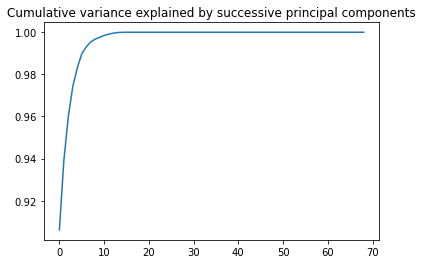

In [10]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative variance explained by successive principal components')

In [ ]:
# idea 1: get the first few axes and eigenvalues, set those as ground truth axes 
# and latent GP scaling factors

# idea 2: use the full correlation matrix
# how to detangle the input correlation and task cor*relation?
# use kronecker structure?
# Suppose we have a vanilla Matern kernel over all inputs for all metrics
# is it as simple as idea 1, just using all axes, 
# or is there something else we can do?